# Extension : Monte carlo experiment

**Sharpe ratio tutorial** : https://medium.com/@TheQuantPy/is-your-sharpe-ratio-lying-to-you-meet-the-probabilistic-sharpe-ratio-d06077e423e8

**Sharpe ratio youtube tutorial**: https://www.youtube.com/watch?v=aazoO0Db-MI


### Justification for not using moving window

- Time-period is already short so the predicting power would decrease if I used moving window because then the number of observations would be too small

## TODO

1. Run monte carlo simulations on my portfolio and see returns for 1, 10, 25, 50, 100 years
   - https://medium.com/@TheQuantPy/you-need-to-stop-using-the-sharpe-ratio-7dfed7183e48

    > The cryptocurrency market’s extraordinary volatility challenges the CLT’s applicability. Sharp price swings and the lack of fundamental drivers often result in non-normal return distributions. Investors who relied on CLT-based models may have misjudged their portfolio risk.


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from scipy import stats
import shap

In [2]:
var_list = ['MCAP', 'PRC', 'MAXDPRC', 'r1', 'r2', 'r3', 'r4', 'r4_1', 'PRCVOL', 'STDPRCVOL']


In [3]:
db_fin = pd.read_csv("./inter/final_factor_data.csv")



In [4]:
db_all_fs = db_fin.copy()

# Construct equal weighted returns
weekly_ncoins = db_all_fs.groupby(['year', 'week'])['coin_id'].nunique().reset_index(name='ncoins')
weekly_ncoins['weights'] = 1 / weekly_ncoins['ncoins']
db_all_fs = db_all_fs.merge(weekly_ncoins, on=['year', 'week'], how='left')
db_all_fs['lead1wret'] = db_all_fs['next_week_ret'] * db_all_fs['weights']
db_all_fs = db_all_fs.sort_values(by=['coin_id', 'year', 'week'], ascending = True)

# Change NA values to 0 (may be skipped)
db_all_fs = db_all_fs.fillna(0)


In [5]:
# Creating week ids

db_all_fs['week_id'] = db_all_fs.groupby('coin_id').cumcount() + 1


In [6]:
# Creating 'yyyyww'

db_all_fs['yyyyww'] = db_all_fs['year'].astype(str) + db_all_fs['week'].astype(str)
db_all_fs['yyyyww'] = db_all_fs['yyyyww'].astype(int)



In [7]:
db_wtreasury = pd.read_csv("./inter/wtreasury.csv")


In [8]:
db_wtreasury.head(2)

,tres,yyyyww
0,0.000025,20141
1,0.000010,20142


In [9]:
# Add wekly treasuries to construct excess weekly returns
db_all_fs = db_all_fs.merge(db_wtreasury, on='yyyyww', how='left')


In [ ]:
db_all_fs.head(2)

In [ ]:
db_all_fs.shape

### Showing correlation between factors

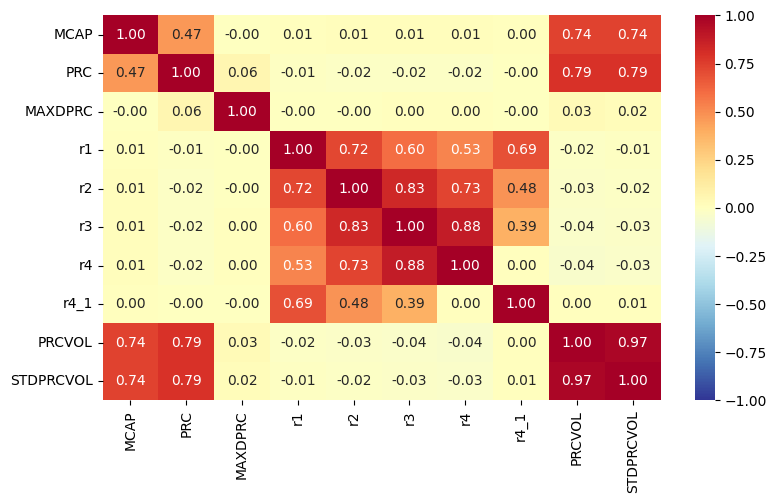

In [10]:
corr_df = db_all_fs[['MCAP', 'PRC', 'MAXDPRC', 'r1', 'r2', 'r3', 'r4', 'r4_1', 'PRCVOL', 'STDPRCVOL']].corr()

plt.figure(figsize=(9, 5))
sns.heatmap(corr_df, cmap="RdYlBu_r", annot=True, fmt=".2f", vmin=-1, vmax=1)
plt.show()



### Ridge model

In [28]:
def ridge_sharpe_tuning(db_all_fs, db_wtreasury, var_list, verbose = 0, save = 0, path = "./output/Ridge/"):
    train_data = db_all_fs.loc[:101416, :]
    test_data = db_all_fs.loc[101417:, :]
    
    Y_train = train_data.loc[:, 'lead1wret']
    X_train = train_data.loc[:, var_list]
    Y_test = test_data.loc[:, 'lead1wret']
    X_test = test_data.loc[:, var_list]

    # Imortant to scale values before running Ridge
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)
    #------------------------------------------
    model = Ridge()
    alphas = [0.000000001, 0.0001, 1, 10, 100, 1000, 2000, 3000, 10000]
    param_grid = {'alpha': alphas}
    
    # Hyperparameters tuning
    grid_search = GridSearchCV(
        estimator = model, 
        param_grid = param_grid,
        scoring = 'neg_mean_squared_error',
        cv = 4,
        n_jobs = 4
    )
    grid_search.fit(X_train_s, Y_train)    
    best_alpha = grid_search.best_params_['alpha']
    best_model = grid_search.best_estimator_
    test_score = best_model.score(X_test_s, Y_test)

    if verbose == 1:
        tuning_res = pd.DataFrame({
        "Best_alpha" : [best_alpha],
        "Best_model" : [best_model],
        "Test_score" : [test_score]
        })
        print("Tuning result: \n", tuning_res)
    #-------------------------------------------------
    pred_ret = best_model.predict(X_test_s)
    
    test_data = test_data.copy()
    test_data['lead1wret_pred'] = pred_ret
    result_df = pd.DataFrame()
    test_data = test_data.sort_values(
            by=['year', 'week'], 
            ascending = True
        )

    # Sorting into decile portfolios
    for week in test_data['yyyyww'].unique():
        w_test_data = test_data[test_data['yyyyww'] == week]
        w_test_data = w_test_data.sort_values(
            by=['lead1wret_pred'], 
            ascending = True
        )
        w_test_data['qt'] = pd.qcut(
            w_test_data['lead1wret_pred'], 
            q=10, 
            labels=[_ for _ in range(1, 11)]
        )
        qt_lead1wret = w_test_data.groupby(['qt'])['lead1wret'].sum().reset_index(drop=True)
        qt_lead1wret[10] = qt_lead1wret[9] - qt_lead1wret[0]
        result_df = result_df.copy()
        result_df.loc[:, f'{week}'] = qt_lead1wret
    #---------------------------------------------------
    # MSE / RMSE
    mse = mean_squared_error(Y_test, pred_ret)
    rmse = np.sqrt(mse)
    target_range = np.max(Y_test) - np.min(Y_test)
    percentage_mse = (mse / target_range) * 100
    percentage_rmse = (rmse / target_range) * 100
    #----------------------------------------------------
    coeff = pd.DataFrame(best_model.coef_, index = X_test.columns)
    interc = best_model.intercept_
    result_mean = result_df.T.mean()
    result_std = result_df.T.std()
    result_skew = result_df.T.skew()
    avg_tres = db_wtreasury['tres'].mean()
    sharpe = (result_mean - avg_tres) / result_std  
    #----------------------------------------------------
    # Calculating mean SHAP
    model_for_explainer = Ridge(alpha=2000)
    model_for_explainer.fit(X_train_s, Y_train)   
    explainer = shap.Explainer(model_for_explainer, X_train_s)
    shap_values = explainer.shap_values(X_test_s)
    abs_shap_values = np.abs(shap_values)
    mean_abs_shap = np.mean(abs_shap_values, axis=0)
    feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean_SHAP': mean_abs_shap
    })
    feature_importance_df = feature_importance_df.sort_values(by='Mean_SHAP', ascending=False)
    #----------------------------------------------------
    if verbose == 1:
        print("\nFeature importance df :\n", feature_importance_df)
        mse_df = pd.DataFrame({
            "MSE" : [mse],
            "RMSE" : [rmse],
            "Perc_MSE" : [percentage_mse],
            "Perc_RMSE" : [percentage_rmse]
        })
        print("\nMSE and RMSE :\n", mse_df)
        print("\nSharpe :\n", sharpe)
        print("\nMean rets:\n", result_mean)
        print("\nSTD:\n", result_std)
        print("\nSkewness:\n", result_skew)

    if save == 1: 
        mse_df.to_csv(f"{path}MSE.csv", index = False)
        feature_importance_df.to_csv(f"{path}mean_SHAP.csv", index = False)
        result_std.to_csv(f"{path}std_rets.csv", index = False)
        result_mean.to_csv(f"{path}mean_rets.csv", index = False)
        result_skew.to_csv(f"{path}skew.csv", index = False)
        sharpe.to_csv(f"{path}sharpe.csv", index = False)

ridge_sharpe_tuning(db_all_fs, db_wtreasury, var_list, save = 1,verbose = 1)



Tuning result: 
    Best_alpha         Best_model  Test_score
0        2000  Ridge(alpha=2000)     0.01194

Feature importance df :
      Feature     Mean_SHAP
8     PRCVOL  1.619697e-04
1        PRC  4.888687e-05
9  STDPRCVOL  2.006842e-05
3         r1  1.698607e-05
6         r4  1.103737e-05
4         r2  9.259072e-06
5         r3  8.666703e-06
0       MCAP  7.952411e-06
7       r4_1  2.346599e-06
2    MAXDPRC  2.990533e-09

MSE and RMSE :
         MSE      RMSE  Perc_MSE  Perc_RMSE
0  0.000002  0.001444  0.001681   1.163946

Sharpe :
 0    -0.471809
1    -0.543470
2    -0.483370
3    -0.233276
4    -0.012683
5    -0.284304
6    -0.098545
7    -0.145756
8     0.183478
9     0.536900
10    0.537333
dtype: float64

Mean rets:
 0     0.000304
1     0.000186
2     0.000406
3     0.001010
4     0.001872
5     0.001200
6     0.001591
7     0.001542
8     0.003631
9     0.011583
10    0.011279
dtype: float64

STD:
 0     0.003497
1     0.003252
2     0.003201
3     0.004046
4     0.006443
5

### Monte Carlo experiment based on portfolios predicted by Ridge

In [29]:
# True weekly returns by portfolio
# Results from : Ridge with excess returns and hyper-parameter tuning

portfolios_weekly = [
    {
        'true_mean' : 0.000304,
        'true_std' :  0.003497,
        'true_skew' : 3.299790
    },
    {
        'true_mean' : 0.000186,
        'true_std' : 0.003252,
        'true_skew' : 1.754901
    },
    {
        'true_mean' : 0.000406,
        'true_std' : 0.003201,
        'true_skew' : -0.467921
    },
    {
        'true_mean' : 0.001010,
        'true_std' : 0.004046,
        'true_skew' : 1.584885
    },
    {
        'true_mean' : 0.001872,
        'true_std' : 0.006443,
        'true_skew' : 6.379582
    },
    {
        'true_mean' : 0.001200,
        'true_std' : 0.002653,
        'true_skew' : 0.125338
    },
    {
        'true_mean' : 0.001591,
        'true_std' : 0.003680,
        'true_skew' : 1.137817
    },
    {
        'true_mean' : 0.001542,
        'true_std' : 0.002827,
        'true_skew' : 1.388112
    },
    {
        'true_mean' : 0.003631,
        'true_std' : 0.009138,
        'true_skew' : 5.103636
    },
    {
        'true_mean' : 0.011583,
        'true_std' : 0.017935,
        'true_skew' : 4.672089
    },
    {
        'true_mean' : 0.011279,
        'true_std' : 0.017355,
        'true_skew' : 4.578301
    }
]         


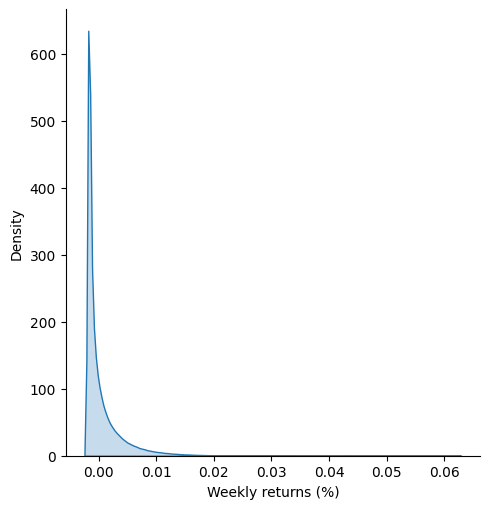

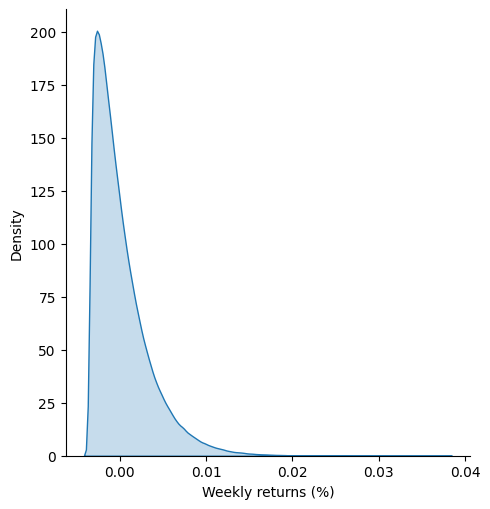

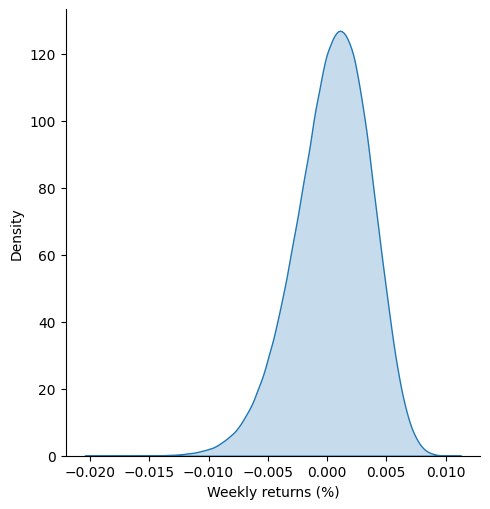

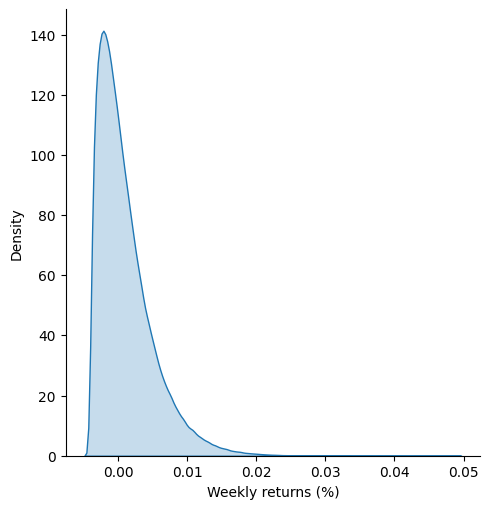

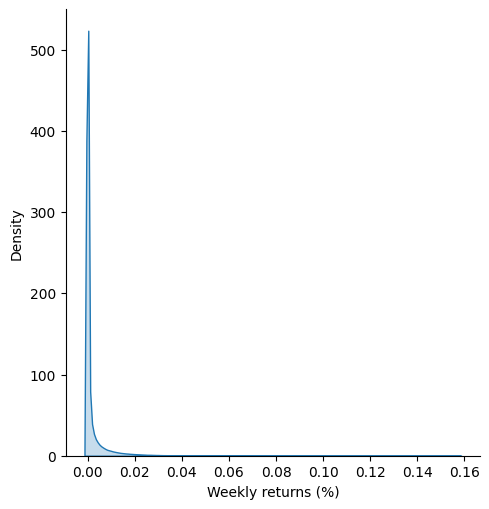

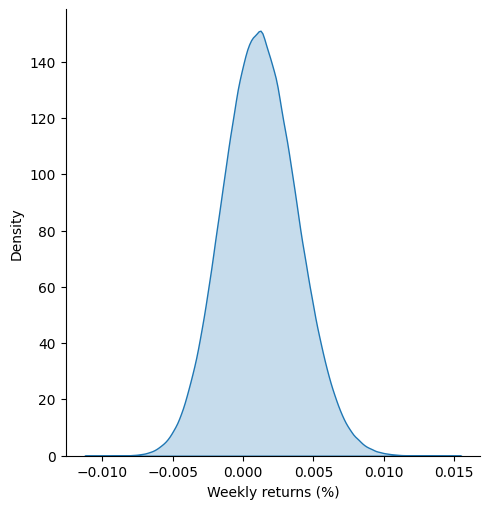

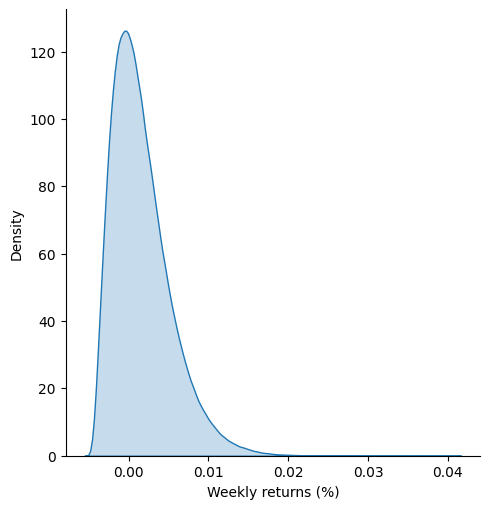

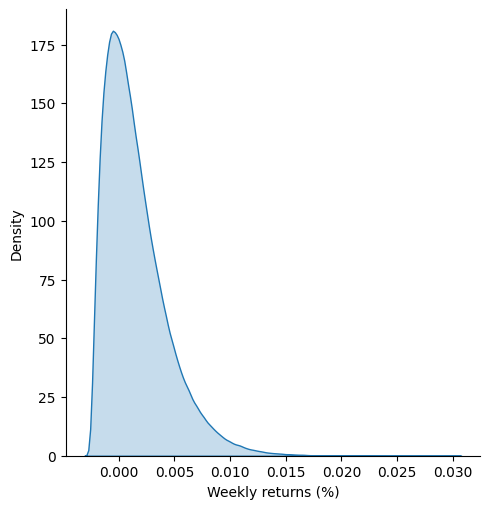

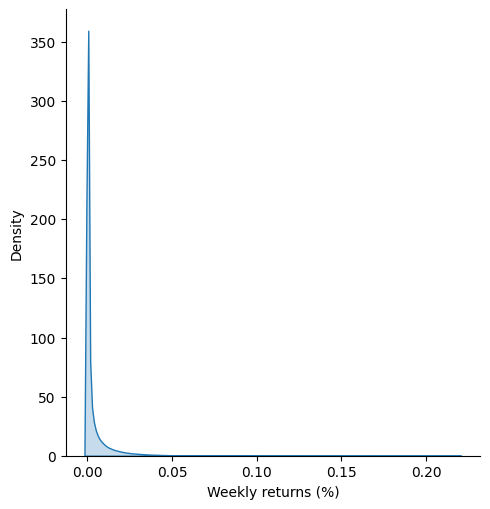

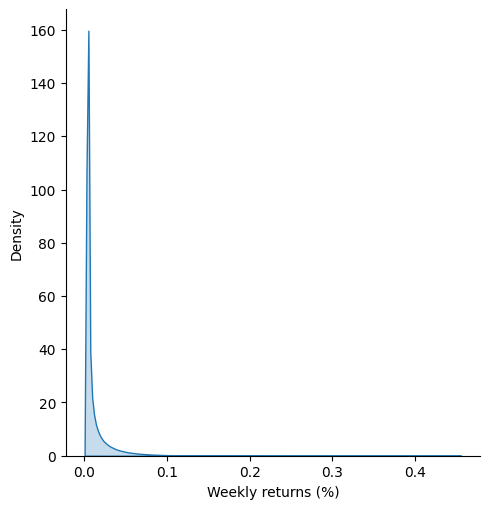

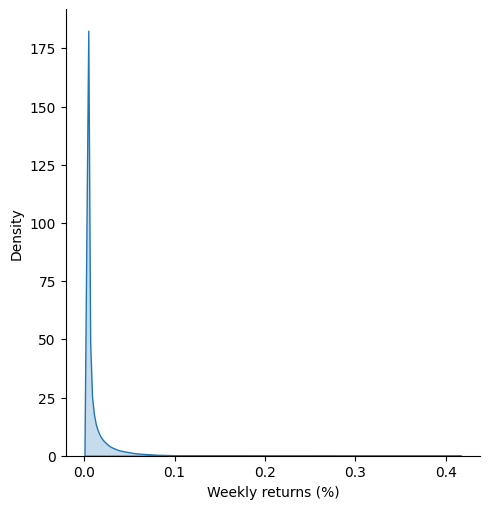

In [31]:
# Plot the distribution of each of 10 portfolios

# Generate random samples from Pearson Type III distribution
for i in portfolios_weekly:
    # Generate random samples for each distribution
    ind = int(portfolios_weekly.index(i)) + 1
    dist_skew = stats.pearson3.rvs(
        loc = i['true_mean'], scale = i['true_std'], 
        skew = i['true_skew'], size = int(1e6)
    )
    sns_dist = sns.displot(dist_skew, kind = 'kde', fill = True)
    plt.xlabel('Weekly returns (%)')
    plt.show()


10000
[0.49749647 0.49793097 0.62828965 ... 0.4844428  0.87355416 0.53966136]


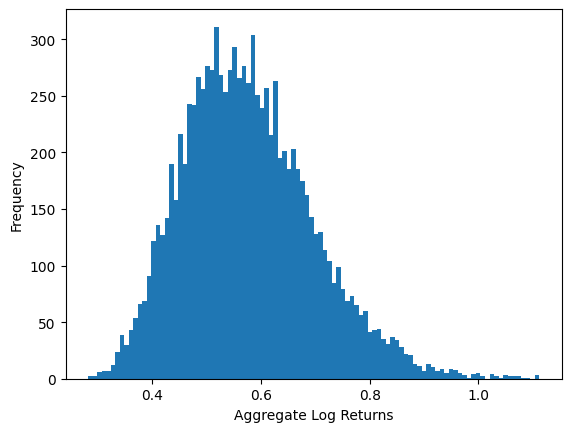

The monte carlo mean estimate is: 0.58
The monte carlo standard error is: 0.0023


In [32]:
# Monte carlo sim
#define holding period
weeks = 52
#number of theoretical simulations
M = 10000
#sample from distribution of returns
r_sample = stats.pearson3.rvs(loc = portfolios_weekly[10]['true_mean'], 
                              scale = portfolios_weekly[10]['true_std'], 
                              skew = portfolios_weekly[10]['true_skew'],  
                              size = (weeks, M))

log_returns = np.log(1 + r_sample)
X = np.cumsum(log_returns, axis = 0)
X_T = X[-1,:]
print(len(X_T))
print(X_T)
plt.hist(X_T, bins = 100)
plt.ylabel('Frequency')
plt.xlabel('Aggregate Log Returns')
plt.show()
print(f"The monte carlo mean estimate is: {np.nanmean(X_T):.2f}")
print(f"The monte carlo standard error is: {1.96*np.nanstd(X_T)/np.sqrt(M):.4f}")


### XGB Sharpe

In [34]:
# !!! Warning : long running time 
'''
Best Hyperparameters: {'colsample_bytree': 1, 'early_stopping_rounds': 0, 
'eval_metric': 'rmse', 'gamma': 1e-07, 
'learning_rate': 1e-05, 'max_depth': 20, 
'min_child_weight': 10, 'n_estimators': 200, 'subsample': 0.5}
'''

def xgb_sharpe_tuning(db_all_fs, db_wtreasury, var_list, verbose = 0, save = 0, path = "./output/XGB/"):
    train_data = db_all_fs.loc[:101416, :]
    test_data = db_all_fs.loc[101417:, :]
    
    Y_train = train_data.loc[:, 'lead1wret']
    X_train = train_data.loc[:, var_list]
    Y_test = test_data.loc[:, 'lead1wret']
    X_test = test_data.loc[:, var_list]

    model = xgb.XGBRegressor()

    param_grid = {
    'learning_rate': [0.00001],
    'max_depth': [2, 20, 100, 300, 1000],
    'n_estimators': [200],
    'subsample': [0.5, 1],
    'colsample_bytree': [0.5, 1],
    'min_child_weight': [50, 10, 300],
    'gamma': [0.0005, 0.0000001, 0.2],
    #'n_rounds': [10],
    'eval_metric': ['rmse'],
    'early_stopping_rounds': [0]
    }

    grid_search = GridSearchCV(
        estimator = model, 
        param_grid = param_grid,
        scoring = 'neg_mean_squared_error',
        cv = 2,
        n_jobs = 4
    )

    grid_search.fit(X_train, Y_train)

    if verbose == 1:
        print("Best Hyperparameters:\n", grid_search.best_params_)

    best_model = grid_search.best_estimator_
    pred_ret = best_model.predict(X_test) 
    test_data = test_data.copy()
    test_data['lead1wret_pred'] = pred_ret  
    result_df = pd.DataFrame()
    test_data = test_data.sort_values(
            by=['year', 'week'], 
            ascending = True
        )
    
    for week in test_data['yyyyww'].unique():
        w_test_data = test_data[test_data['yyyyww'] == week]
        w_test_data = w_test_data.sort_values(
            by=['lead1wret_pred'], 
            ascending = True
        )
        w_test_data['qt'] = pd.qcut(
            w_test_data['lead1wret_pred'], 
            q=10, 
            labels=[_ for _ in range(1, 11)]
        )
        qt_lead1wret = w_test_data.groupby(['qt'])['lead1wret'].sum().reset_index(drop=True)
        qt_lead1wret[10] = qt_lead1wret[9] - qt_lead1wret[0]
        result_df = result_df.copy()
        result_df.loc[:, f'{week}'] = qt_lead1wret
    #---------------------------------------------------
    # MSE / RMSE
    mse = mean_squared_error(Y_test, pred_ret)
    rmse = np.sqrt(mse)
    target_range = np.max(Y_test) - np.min(Y_test)
    percentage_mse = (mse / target_range) * 100
    percentage_rmse = (rmse / target_range) * 100
    #----------------------------------------------------
    result_mean = result_df.T.mean()
    result_std = result_df.T.std()
    result_skew = result_df.T.skew()
    avg_tres = db_wtreasury['tres'].mean()
    sharpe = (result_mean - avg_tres) / result_std  
    #----------------------------------------------------
    # calculating mean SHAP
    model_for_explainer = xgb.XGBRegressor(
        colsample_bytree = 1, 
        early_stopping_rounds = 0, 
        eval_metric = 'rmse', 
        gamma = 0.0000001, 
        learning_rate = 0.00001, 
        max_depth = 20, 
        min_child_weight = 10, 
        n_estimators = 200, 
        subsample = 0.5
    )
    model_for_explainer.fit(X_train, Y_train)   
    explainer = shap.Explainer(model_for_explainer, X_train)
    shap_values = explainer.shap_values(X_test)
    abs_shap_values = np.abs(shap_values)
    mean_abs_shap = np.mean(abs_shap_values, axis=0)
    feature_importance_df = pd.DataFrame({
    'Feature': X_test.columns,
    'Mean_SHAP': mean_abs_shap
    })
    feature_importance_df = feature_importance_df.sort_values(by='Mean_SHAP', ascending=False)
    #----------------------------------------------------
    if verbose == 1:
        mse_df = pd.DataFrame({
            "MSE" : [mse],
            "RMSE" : [rmse],
            "Perc_MSE" : [percentage_mse],
            "Perc_RMSE" : [percentage_rmse]
        })
        print("\nMSE and RMSE :\n", mse_df)
        print("\nMean rets :\n", result_mean)
        print("\nSTD ret :\n", result_std)
        print("\nSharpe :\n", sharpe)
        print("\nSkewness :\n", result_skew)
        # print("\nSHAP:\n", feature_importance_df)

    if save == 1:
        mse_df.to_csv(f"{path}mse.csv", index=False)
        result_std.to_csv(f"{path}std_rets.csv", index=False)
        result_mean.to_csv(f"{path}mean_rets.csv", index=False)
        sharpe.to_csv(f"{path}sharpe.csv", index=False)
        result_skew.to_csv(f"{path}skewness.csv", index=False)
        # feature_importance_df.to_csv(f"{path}shap.csv", index=False)

xgb_sharpe_tuning(db_all_fs, db_wtreasury, var_list, save = 1, verbose = 1)


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Best Hyperparameters:
 {'colsample_bytree': 1, 'early_stopping_rounds': 0, 'eval_metric': 'rmse', 'gamma': 1e-07, 'learning_rate': 1e-05, 'max_depth': 20, 'min_child_weight': 10, 'n_estimators': 200, 'subsample': 0.5}

MSE and RMSE :
         MSE      RMSE  Perc_MSE  Perc_RMSE
0  0.000002  0.001454  0.001704   1.171685

Mean rets :
 0     0.003420
1     0.000382
2     0.000286
3     0.000664
4     0.000469
5     0.001926
6     0.000960
7     0.001738
8     0.002507
9     0.010975
10    0.007555
dtype: float64

STD ret :
 0     0.013417
1     0.002913
2     0.002706
3     0.003639
4     0.002945
5     0.006655
6     0.003130
7     0.002959
8     0.005246
9     0.014695
10    0.019751
dtype: float64

Sharpe :
 0     0.109268
1    -0.539515
2    -0.616622
3    -0.354586
4    -0.504335
5    -0.004189
6    -0.317687
7    -0.073055
8     0.105510
9     0.613884
10    0.283589
dtype: float64

Skewness :
 0     5.616828
1    -0.609857
2    -1.323563
3     1.926501
4    -0.660391
5     5.697875

### Monte Carlo experiment based on portfolios predicted by XGB

In [35]:
# True weekly returns by portfolio
# Results from : XGB with excess returns and hyper-parameter tuning

portfolios_weekly = [
    {
        'true_mean' : 0.003420,
        'true_std' : 0.013417,
        'true_skew' : 5.616828
    },
    {
        'true_mean' : 0.000382,
        'true_std' : 0.002913,
        'true_skew' : -0.609857
    },
    {
        'true_mean' : 0.000286,
        'true_std' : 0.002706,
        'true_skew' : -1.323563
    },
    {
        'true_mean' : 0.000664,
        'true_std' : 0.003639,
        'true_skew' : 1.926501
    },
    {
        'true_mean' : 0.000469,
        'true_std' : 0.002945,
        'true_skew' : -0.660391
    },
    {
        'true_mean' : 0.000469,
        'true_std' : 0.006655,
        'true_skew' : 5.697875
    },
    {
        'true_mean' : 0.000960,
        'true_std' : 0.003130,
        'true_skew' : 0.680839
    },
    {
        'true_mean' : 0.001738,
        'true_std' : 0.002959,
        'true_skew' : 0.306756
    },
    {
        'true_mean' : 0.002507,
        'true_std' : 0.005246,
        'true_skew' : 3.935353
    },
    {
        'true_mean' : 0.010975,
        'true_std' : 0.014695,
        'true_skew' : 4.984160
    },
    {
        'true_mean' : 0.007555,
        'true_std' : 0.019751,
        'true_skew' : 0.446845
    }
]      


In [ ]:
# Plot the distribution of each of 10 portfolios

# Generate random samples from Pearson Type III distribution
for i in portfolios_weekly:
    # Generate random samples for each distribution
    ind = int(portfolios_weekly.index(i)) + 1
    dist_skew = stats.pearson3.rvs(
        loc = i['true_mean'], scale = i['true_std'], 
        skew = i['true_skew'], size = int(1e6)
    )
    sns_dist = sns.displot(dist_skew, kind = 'kde', fill = True)
    plt.title(f'Returns Distribution of portfolio {ind}: \n$X \sim r_P$ ')
    plt.xlabel('Weekly returns (%)')
    plt.show()


10000
[0.34442989 0.27838763 0.44055108 ... 0.50544851 0.1268086  0.41396189]


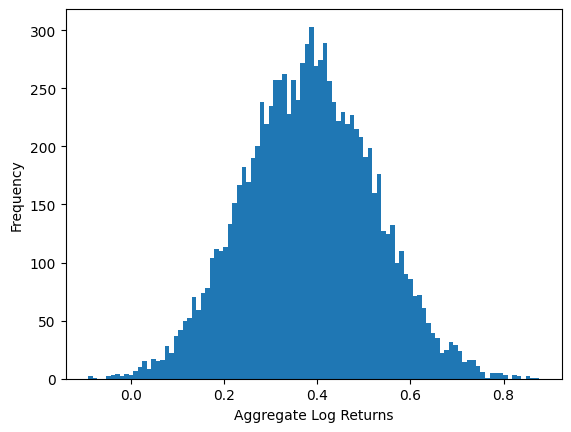

The monte carlo mean estimate is: 0.38
The monte carlo standard error is: 0.0027


In [36]:
# Monte carlo sim
#define holding period
weeks = 52
#number of theoretical simulations
M = 10000
#sample from distribution of returns
r_sample = stats.pearson3.rvs(loc = portfolios_weekly[10]['true_mean'], 
                              scale = portfolios_weekly[10]['true_std'], 
                              skew = portfolios_weekly[10]['true_skew'],  
                              size = (weeks, M))

log_returns = np.log(1 + r_sample)
X = np.cumsum(log_returns, axis = 0)
X_T = X[-1,:]
print(len(X_T))
print(X_T)
plt.hist(X_T, bins = 100)
plt.ylabel('Frequency')
plt.xlabel('Aggregate Log Returns')
plt.show()
print(f"The monte carlo mean estimate is: {np.nanmean(X_T):.2f}")
print(f"The monte carlo standard error is: {1.96*np.nanstd(X_T)/np.sqrt(M):.4f}")
